In [1]:
from libraries import * 
from preprocessing import downloading_loading_processed_files
from utils import enframe
warnings.filterwarnings("ignore")

# selecting GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on GPU = {str(device) == 'cuda'}")

# (down)loading split datasets, can be run twice if kernel dies 1st time
train_set, validation_set, test_set = downloading_loading_processed_files(
    downsampling=False)
print(f"loading of datasets done")

# setting up computational parameters
if device == "cuda":
    num_workers, pin_memory = 4, True
else:
    num_workers, pin_memory = 0, False

running on GPU = False


  0%|          | 10/84843 [00:00<14:53, 94.90it/s]

preprocessing training set


  0%|          | 12/9981 [00:00<01:24, 118.55it/s]

preprocessing validation set


  0%|          | 12/105829 [00:00<15:14, 115.69it/s]

preprocessing test set


 38%|███▊      | 40001/105829 [09:36<15:48, 69.38it/s] 


loading of datasets done


In [2]:
# all element in dataset are shpae 78*13
# about 2,8 to 2,9% of the inputs have nan in it (preprocessing problematic: dataset should be filtered

def remove_nan_in(dataset):
    not_nan_entries = []
    for i, (lmfcc, sample_rate, label, speaker_id, utterance_number) in enumerate(dataset):
        if not np.isnan(lmfcc).any():
            not_nan_entries.append(i)
    return np.array(dataset)[not_nan_entries]

train_set = remove_nan_in(train_set)
validation_set = remove_nan_in(validation_set)

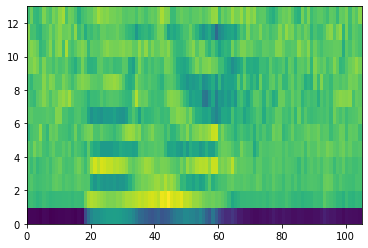

In [3]:
plt.pcolormesh(train_set[10][0].T);

In [4]:
def pad_sequence(batch):
    """ 
    desc: make all tensor in a batch the same length as the longest sequence by padding with zeros 
    """
    batch = [torch.from_numpy(item) for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)  # in each tensor, target first, tensor second

# encoding each word using its index in the list of labels
def label_to_index(word):
    """ 
    desc: return the position of the word in labels 
    """
    return torch.tensor(labels.index(word))
    
def collate_fn(batch):
    """ 
    desc: turn audio's list batch into two batch tensors for model 
    """
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

    
# sets in to dataloaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
    num_workers=num_workers, pin_memory=pin_memory)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=batch_size, shuffle=False, drop_last=False,
    collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=batch_size, shuffle=False, drop_last=False,
    collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
print(f"set up of dataloader done")

set up of dataloader done


In [11]:
# MODEL (adapted from there: https://www.kaggle.com/code/talmanr/cnn-with-pytorch-using-mel-features/notebook)
class CnnAudioNet(nn.Module):
    def __init__(self,NumClasses):
        super(CnnAudioNet,self).__init__()
        self.NumClasses = NumClasses
        self.Fc_features = 128
        self.C1 = nn.Conv2d(1,32,3,padding=1)
        self.C2 = nn.Conv2d(32,32,5,padding=1)
        self.BN1 = nn.BatchNorm2d(32)  # change size of batch norm?
        self.fc1 = nn.Linear(1536,128)
        self.fc2 = nn.Linear(128, self.NumClasses)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        
        self.C3 = nn.Conv2d(32,64,5,padding=1)
        self.BN2 = nn.BatchNorm2d(64)


    def forward(self,x):        
        x = F.relu(self.BN1(self.C1(x)))
        x = self.maxpool1(F.relu(self.BN1(self.C2(x))))
        
        x = self.maxpool1(F.relu(self.BN2(self.C3(x))))
                
        x = (x.view(-1,np.prod(x.shape[1:]))) # self.dropout
        # dim to know here for fully connected
        # print(x.shape)
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        return x

labels = sorted(list(set(datapoint[2] for datapoint in train_set)))  

model = CnnAudioNet(len(labels))
model.to(device)  # convert initialized model to CUDA optimized model
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

  5%|▌         | 1/20 [01:00<19:07, 60.41s/it]

Train batch loss: -63857635.484375,


 10%|█         | 2/20 [02:04<18:29, 61.66s/it]

Train batch loss: -150712671.062500,


 15%|█▌        | 3/20 [03:10<17:48, 62.88s/it]

Train batch loss: -290621097.375000,


 20%|██        | 4/20 [04:17<17:02, 63.94s/it]

Train batch loss: -493117510.250000,


 25%|██▌       | 5/20 [05:23<16:09, 64.66s/it]

Train batch loss: -766743612.750000,


 30%|███       | 6/20 [06:30<15:13, 65.28s/it]

Train batch loss: -1118752786.000000,


 35%|███▌      | 7/20 [07:39<14:23, 66.46s/it]

Train batch loss: -1554164999.000000,


 40%|████      | 8/20 [08:47<13:24, 67.06s/it]

Train batch loss: -2080717829.000000,


 45%|████▌     | 9/20 [09:53<12:13, 66.71s/it]

Train batch loss: -2701382683.000000,


 50%|█████     | 10/20 [10:58<11:02, 66.26s/it]

Train batch loss: -3419940518.000000,


 55%|█████▌    | 11/20 [12:03<09:52, 65.87s/it]

Train batch loss: -4242084390.000000,


 60%|██████    | 12/20 [13:09<08:45, 65.68s/it]

Train batch loss: -5164725858.000000,


 65%|██████▌   | 13/20 [14:14<07:38, 65.53s/it]

Train batch loss: -6198311416.000000,


 70%|███████   | 14/20 [15:19<06:32, 65.45s/it]

Train batch loss: -7346080640.000000,


 75%|███████▌  | 15/20 [16:25<05:27, 65.48s/it]

Train batch loss: -8601240844.000000,


 80%|████████  | 16/20 [17:30<04:21, 65.45s/it]

Train batch loss: -9973244444.000000,


 85%|████████▌ | 17/20 [18:35<03:16, 65.35s/it]

Train batch loss: -11463781624.000000,


 90%|█████████ | 18/20 [19:40<02:10, 65.21s/it]

Train batch loss: -13069943504.000000,


 95%|█████████▌| 19/20 [20:45<01:05, 65.11s/it]

Train batch loss: -14784490200.000000,


100%|██████████| 20/20 [21:52<00:00, 65.61s/it]

Train batch loss: -16634659648.000000,


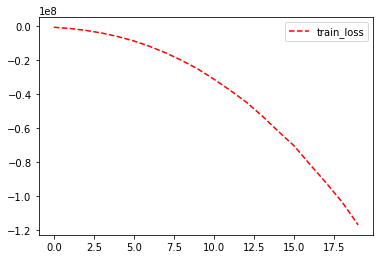

In [14]:
from preprocessing import Preprocessing  # run first with - F.nll_loss 10 iterations, than +F.nll_loss 20 iterations, it works starts to have results, lr 1e-3



processor = Preprocessing(train_set, validation_set, test_set)
model.train()

train_loss_history, nb_epochs = [], 20
valid_loss_history = []
for epoch in tqdm(range(nb_epochs)):
    
    # train and eval train loss
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):

        print(target)
        target = target.to(device)
        data = (data-data.mean())/data.std()

        data = data.to(device, dtype=torch.float)
        output = model(data.unsqueeze(1))
        _, pred = torch.max(output,1)

        # negative log-likelihood for tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output, target)

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()

        train_loss += loss.item()
    print('Train batch loss: {:.6f},'.format(train_loss))
    train_loss_history.append(loss)
    
#     # eval val loss
#     with torch.no_grad():
#         model.eval()
#         valid_loss = 0 
#         for data, target in validation_loader:
            
#             target = target.to(device)
#             data = data.to(device, dtype=torch.float)
#             output = model(data.unsqueeze(1))
#             _,pred = torch.max(output,1)
            
#             loss = F.nll_loss(output, target)
#             valid_loss += loss.item()
#     valid_loss_history.append(valid_loss)
            
            

    
plt.plot(train_loss_history, "r--", label="train_loss")
# plt.plot(valid_loss_history, "g--", label="val_loss")
plt.legend();

In [15]:
pred

tensor([17, 17,  7, 17, 17, 17,  7, 17, 17, 17, 17, 17,  7, 17,  7, 17,  7,  7,
         7, 17,  7, 17,  7,  7, 17, 17, 17,  7, 17,  7,  7, 17, 17, 17, 17, 17,
        17, 17,  7,  7, 17,  7,  6, 17, 17,  7, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17,  7, 17, 17, 17,  7, 17, 17, 17,  6,  5,
        17, 17, 17, 17, 17, 17, 17, 17,  7, 17, 17,  7, 17, 17, 17, 17, 17,  7,
        17, 17, 17, 17, 17, 17, 17, 17,  6,  7,  7, 17,  7,  5,  7, 17, 17, 17,
         7, 17, 17, 17, 17, 17,  7, 17, 17,  7, 17,  7, 17, 17, 17, 17,  7,  7,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,  7,  7, 17,  7,  7, 17,  6,
        17,  7, 17, 17,  7,  6, 17, 17, 17, 17,  7, 17, 17, 17, 17,  7, 17, 17,
        17, 17,  7, 17, 17, 17, 17,  7, 17, 17, 17,  7, 17, 17, 17,  7, 17, 17,
        17,  6,  7, 17,  6, 17, 17, 17, 17, 17,  7, 17, 17, 17, 17,  7, 17, 17,
        17, 17,  7, 17, 17, 17, 17, 17, 17, 17,  7, 17, 17,  7, 17, 17, 17, 17,
         7,  7,  7,  7, 17, 17, 17, 17, 

In [16]:
target

tensor([16, 10,  0, 11, 17,  2, 17, 17, 10,  6,  1, 16, 16,  7, 15, 15, 10, 17,
        13, 16, 17, 11,  0,  6,  3, 17,  1,  2, 12, 11,  1,  6,  2,  7, 15,  0,
         9,  4, 14, 11,  5, 17, 15,  0,  8, 10, 16,  1,  2,  5,  0, 12, 17,  4,
        13,  0, 10,  9,  2,  5, 18,  8,  7,  5, 11, 16,  1, 12,  6,  6, 17,  1,
         0, 11,  5, 14, 17,  0,  6, 15, 15, 11,  3, 17, 13,  3,  9,  0,  5,  7,
         5,  4, 16,  5, 16,  1, 18,  0,  4,  5,  6,  1,  1, 16, 18,  0,  9,  7,
         6, 11, 10,  2, 14,  2,  0, 10,  3,  2,  2, 14,  6, 10, 13,  3,  8, 17,
         8,  8, 17, 14, 18,  7,  9, 12, 14, 11, 17, 17, 10,  7,  7, 11,  6, 18,
         5,  5, 14,  4, 15, 12, 16,  4,  1, 12,  4, 17,  4,  2, 11,  0,  2,  7,
        12,  6, 17,  9,  5, 10, 17, 11, 14,  7,  2, 11, 17, 15, 11,  6, 10, 14,
        12, 12,  5, 11,  1, 17, 13,  1,  1,  6,  1,  4,  7,  8,  7,  2, 15,  2,
        14, 16,  4, 14,  7, 12, 15,  4,  8, 18, 11, 16, 16, 13, 17,  6,  5, 12,
         5,  5, 10,  2,  0,  7, 15,  8, 

In [17]:
from preprocessing import Preprocessing  # run first with - F.nll_loss 10 iterations, than +F.nll_loss 20 iterations, it works starts to have results, lr 1e-3



processor = Preprocessing(train_set, validation_set, test_set)
model.train()

train_loss_history, nb_epochs = [], 20
valid_loss_history = []
for epoch in tqdm(range(nb_epochs)):
    
    # train and eval train loss
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):

        print(target)
        target = target.to(device)
        data = (data-data.mean())/data.std()

        data = data.to(device, dtype=torch.float)
        output = model(data.unsqueeze(1))
        _, pred = torch.max(output,1)

        # negative log-likelihood for tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output, target)

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()

        train_loss += loss.item()
    print('Train batch loss: {:.6f},'.format(train_loss))
    train_loss_history.append(loss)
    
#     # eval val loss
#     with torch.no_grad():
#         model.eval()
#         valid_loss = 0 
#         for data, target in validation_loader:
            
#             target = target.to(device)
#             data = data.to(device, dtype=torch.float)
#             output = model(data.unsqueeze(1))
#             _,pred = torch.max(output,1)
            
#             loss = F.nll_loss(output, target)
#             valid_loss += loss.item()
#     valid_loss_history.append(valid_loss)
            
            

    
plt.plot(train_loss_history, "r--", label="train_loss")
# plt.plot(valid_loss_history, "g--", label="val_loss")
plt.legend();

  0%|          | 0/20 [00:00<?, ?it/s]

tensor([10, 17, 15, 13,  4,  9, 14, 17,  7,  6,  0, 15, 15, 10, 17,  7,  7,  7,
         7,  5, 11,  4, 10,  5, 15,  9, 11, 17,  4,  8, 11, 12,  6,  9,  6, 13,
         7, 16,  5, 17, 11, 14,  3, 15,  4, 16, 12, 13,  3,  3,  5, 17, 13,  7,
         5, 13,  2,  5,  7, 12,  1, 15, 10, 10, 15,  5,  3,  9,  6,  2, 11,  3,
         4, 10,  5,  8, 11,  6, 11, 15, 13,  4, 11,  9,  6,  9, 11,  9,  2, 15,
        14,  8, 11,  0,  9,  5,  6,  4, 16,  7, 14, 10,  8,  6, 16,  3, 16,  5,
        18, 12, 16, 17, 17, 16,  8,  3,  7, 17, 16,  1,  9,  7, 15, 16, 14, 16,
         6,  3,  5, 18,  1, 13,  4,  5, 10,  7, 17,  1,  8, 14,  6,  5,  2, 15,
        18,  1,  7,  6, 15,  7,  5,  3, 15,  1,  3, 13, 10,  5, 15,  6,  4, 13,
         1, 12, 14,  5, 10, 18,  5, 16, 16,  9,  3, 15,  4,  3, 10,  6, 15, 18,
         7, 10,  0, 15,  4, 17,  9, 13, 16,  6, 13, 17, 15,  5, 15, 12, 15,  7,
         4,  6, 16, 16,  9, 11,  8, 11, 10, 12, 10, 15, 11,  7, 10, 11,  9, 17,
        16, 15,  5, 12, 16,  9,  5,  1, 

  0%|          | 0/20 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [13]:
np.max(train_set[100][0])

674.9401492337615